# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [44]:
import sys
from pathlib import Path
import re
def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /home/zohra/mlfs-book
HopsworksSettings initialized!


In [50]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util
import os
import importlib
importlib.reload(util)

<module 'mlfs.airquality.util' from '/home/zohra/mlfs-book/mlfs/airquality/util.py'>

In [46]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 16, 13, 29, 6, 98265)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [4]:
project = hopsworks.login(engine="python")
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)

2025-11-16 12:28:49,960 INFO: Initializing external client
2025-11-16 12:28:49,961 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-16 12:28:50,737 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-16 12:28:51,610 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1279126


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [5]:
mr = project.get_model_registry()
air_quality_fg = fs.get_feature_group(
    name='air_quality_per_city',
    version=2,
)
target_city = "catalunya"

city_info = next(
    loc for loc in location 
    if loc["city"].lower() == target_city.lower()
)
country = city_info["country"]
city =target_city
weather_fg = fs.get_feature_group(
    name='weather_spain',
    version=1,
)
selected_features = (
    air_quality_fg
    .select(['pm25', 'date', 'rolling_mean', 'city', 'street'])
    .join(
        weather_fg.select_features(),
        on=['city']
    )
)

selected_features_df = selected_features.read().sort_values("date")


streets = selected_features_df["street"].dropna().unique()
models_by_street = {}

for s in streets:
    safe_street = re.sub(r"[^A-Za-z0-9]+", "_", s)
    model_name = "air_quality_xgboost_" + re.sub(r"[^A-Za-z0-9]+","_", s)

    try:
        retrieved_model = mr.get_model(name=model_name, version=1)
        models_by_street[s] = retrieved_model
        print(f" Found model '{model_name}' for street '{s}'")
    except Exception as e:
        print(f" No model for street '{s}' with name '{model_name}'")


2025-11-16 12:28:55,446 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather_spain` as features for the query. To include primary key and event time use `select_all`.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.06s) 
 Found model 'air_quality_xgboost_barcelona_gracia_st_gervasi' for street 'barcelona-gracia-st.gervasi'
 Found model 'air_quality_xgboost_barcelona_parc_vall_dhebron' for street 'barcelona-parc-vall-dhebron'
 Found model 'air_quality_xgboost_barcelona' for street 'barcelona'
 Found model 'air_quality_xgboost_barcelona_eixample' for street 'barcelona-eixample'
 Found model 'air_quality_xgboost_barcelona_palau_reial' for street 'barcelona-palau-reial'
 Found model 'air_quality_xgboost_barcelona_poblenou' for street 'barcelona-poblenou'


In [6]:
import os
from xgboost import XGBRegressor

xgb_models = {} 

for street, model_meta in models_by_street.items():
    print(street, "->", model_meta)
    # 1) Download the directory for this street’s model
    model_dir = model_meta.download()
    
    # 2) Find the model JSON file automatically
    model_json = None
    for f in os.listdir(model_dir):
        if f.endswith(".json"):
            model_json = os.path.join(model_dir, f)
            break

    if model_json is None:
        print(f" No JSON model file found for {street}")
        continue

    # 3) Load into XGBoost
    model = XGBRegressor()
    model.load_model(model_json)

    xgb_models[street] = model
    print(f" Loaded XGBoost model for {street}")


barcelona-gracia-st.gervasi -> Model(name: 'air_quality_xgboost_barcelona_gracia_st_gervasi', version: 1)


Downloading: 0.000%|          | 0/443483 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/452516 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/110543 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/111816 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/20304 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/18686 elapsed<00:00 remaining<?

 Loaded XGBoost model for barcelona-gracia-st.gervasi
barcelona-parc-vall-dhebron -> Model(name: 'air_quality_xgboost_barcelona_parc_vall_dhebron', version: 1)


Downloading: 0.000%|          | 0/443483 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/452516 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/110543 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/111816 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/20304 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/18686 elapsed<00:00 remaining<?

 Loaded XGBoost model for barcelona-parc-vall-dhebron
barcelona -> Model(name: 'air_quality_xgboost_barcelona', version: 1)


Downloading: 0.000%|          | 0/443483 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/452516 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/110543 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/111816 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/20304 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/18686 elapsed<00:00 remaining<?

 Loaded XGBoost model for barcelona 6 files)... DONE
barcelona-eixample -> Model(name: 'air_quality_xgboost_barcelona_eixample', version: 1)


Downloading: 0.000%|          | 0/443483 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/452516 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/110543 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/111816 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/20304 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/18686 elapsed<00:00 remaining<?

 Loaded XGBoost model for barcelona-eixample... DONE
barcelona-palau-reial -> Model(name: 'air_quality_xgboost_barcelona_palau_reial', version: 1)


Downloading: 0.000%|          | 0/443483 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/452516 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/110543 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/111816 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/20304 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/18686 elapsed<00:00 remaining<?

 Loaded XGBoost model for barcelona-palau-reial DONE
barcelona-poblenou -> Model(name: 'air_quality_xgboost_barcelona_poblenou', version: 1)


Downloading: 0.000%|          | 0/443483 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/452516 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/110543 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/111816 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/20304 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/18686 elapsed<00:00 remaining<?

 Loaded XGBoost model for barcelona-poblenou... DONE


In [7]:
air_quality_df = air_quality_fg.read()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.51s) 


In [14]:
batch_data = weather_fg.filter(weather_fg.date >= today).read()
m=batch_data.sort_values("date", ascending=True).copy()
m

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.62s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
4,2025-11-17 00:00:00+00:00,12.65,0.0,8.766573,199.179108,catalunya
1,2025-11-18 00:00:00+00:00,6.80,0.0,6.489992,236.309906,catalunya
5,2025-11-19 00:00:00+00:00,5.15,0.0,6.287130,246.370605,catalunya
0,2025-11-20 00:00:00+00:00,4.85,0.0,7.895416,223.152405,catalunya
2,2025-11-21 00:00:00+00:00,4.90,0.0,23.411074,358.237640,catalunya
3,2025-11-22 00:00:00+00:00,7.05,0.0,7.172949,252.474335,catalunya


In [15]:
def recursive_predict_with_rolling_3(model, air_quality_df, batch_data):
   

    # Make sure historical data is ordered from most recent to oldest
    hist = air_quality_df.sort_values("date", ascending=False).copy()

    # last 3 *real* pm25 values (most recent first)
    history = list(hist["pm25"].iloc[:3])

    batch_sorted = batch_data.sort_values("date", ascending=True).copy()

    rolling_means = []

    feature_cols = [
        "rolling_mean",
        "temperature_2m_mean",
        "precipitation_sum",
        "wind_speed_10m_max",
        "wind_direction_10m_dominant",
    ]

    for _, row in batch_sorted.iterrows():
    
        window = history[:3]
        rolling_mean = sum(window) / len(window)
        rolling_means.append(rolling_mean)

        # --- build features for this horizon ---
        row_features = row.copy()
        row_features["rolling_mean"] = rolling_mean
        
        X = row_features[feature_cols].to_frame().T
        X = X.astype(float)

        y_hat = model.predict(X)[0]

        history = [y_hat] + history[:2]

    batch_sorted["rolling_mean"] = rolling_means

    # put back in original order if needed
    return batch_sorted


In [16]:
batch_data_by_street = {}
for s in xgb_models.keys():
    batch_data_by_street[s] = recursive_predict_with_rolling_3(
    model=xgb_models[s],
    air_quality_df = air_quality_df[air_quality_df["street"] == s],
    batch_data=batch_data,
)

In [17]:
debug=pd.to_datetime(batch_data_by_street['barcelona']['date']).dt.date
debug

4    2025-11-17
1    2025-11-18
5    2025-11-19
0    2025-11-20
2    2025-11-21
3    2025-11-22
Name: date, dtype: object

In [18]:
for s in batch_data_by_street.keys():
    batch_data_by_street[s]['predicted_pm25'] = xgb_models[s].predict(
    batch_data_by_street[s][['rolling_mean','temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])


In [25]:
for s in batch_data_by_street.keys():
    batch_data_by_street[s]['street'] = s
    batch_data_by_street[s]['city'] = city
    batch_data_by_street[s]['country'] = country
    # Fill in the number of days before the date on which you made the forecast (base_date)
    batch_data_by_street[s]['days_before_forecast_day'] = range(1, len(batch_data)+1)
    batch_data_by_street[s] = batch_data_by_street[s].sort_values(by=['date'])

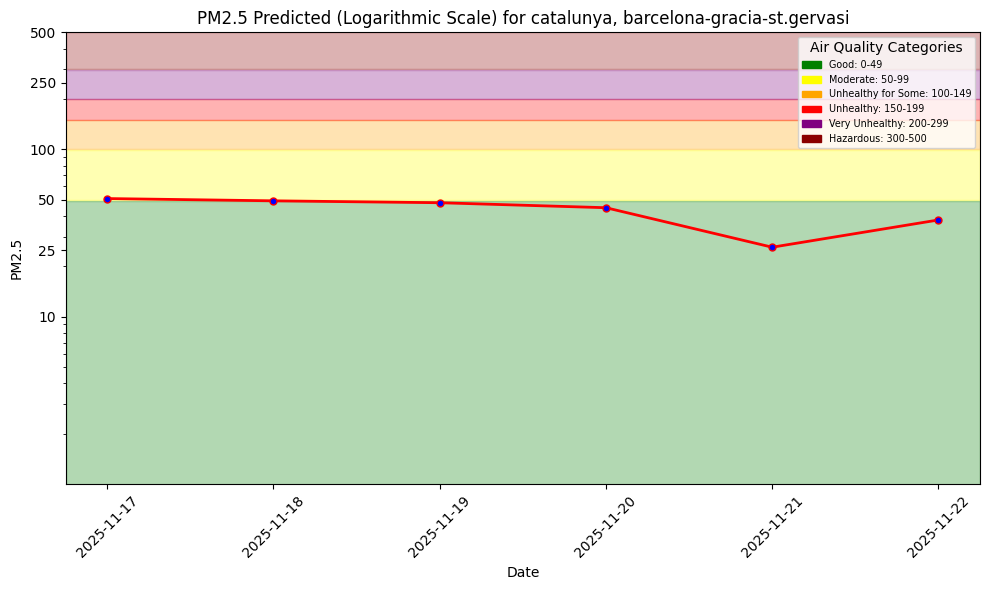

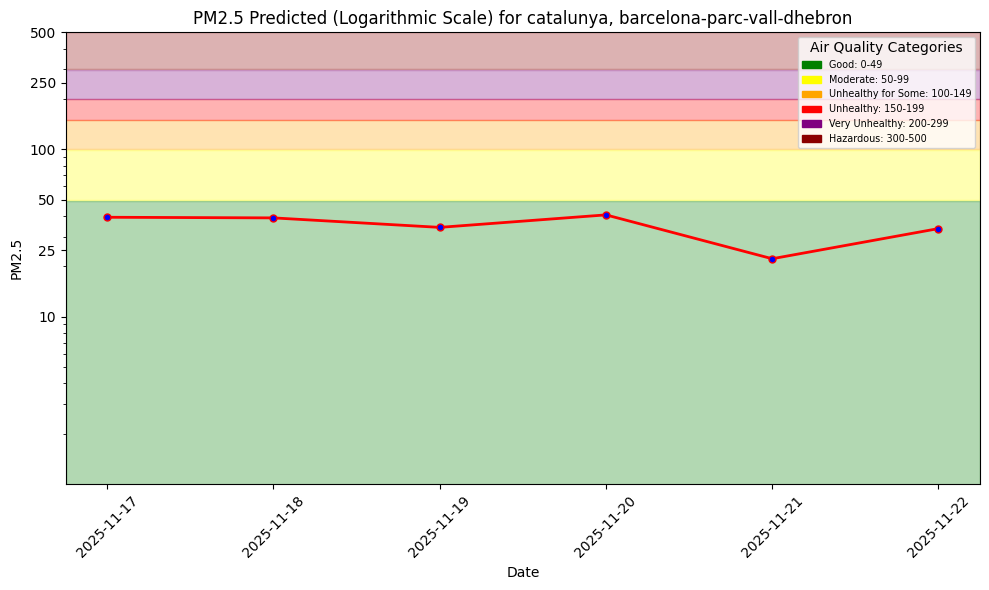

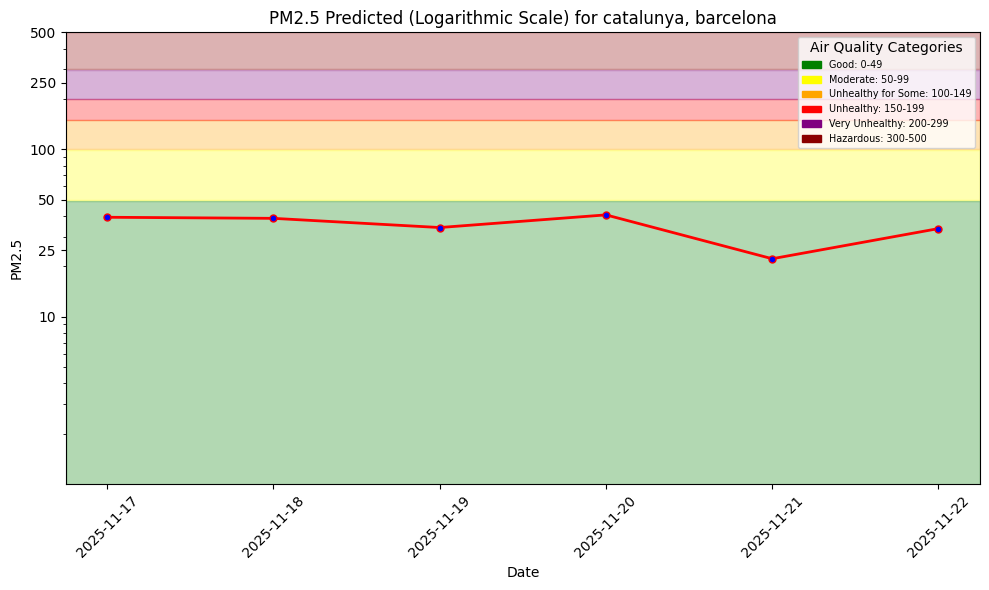

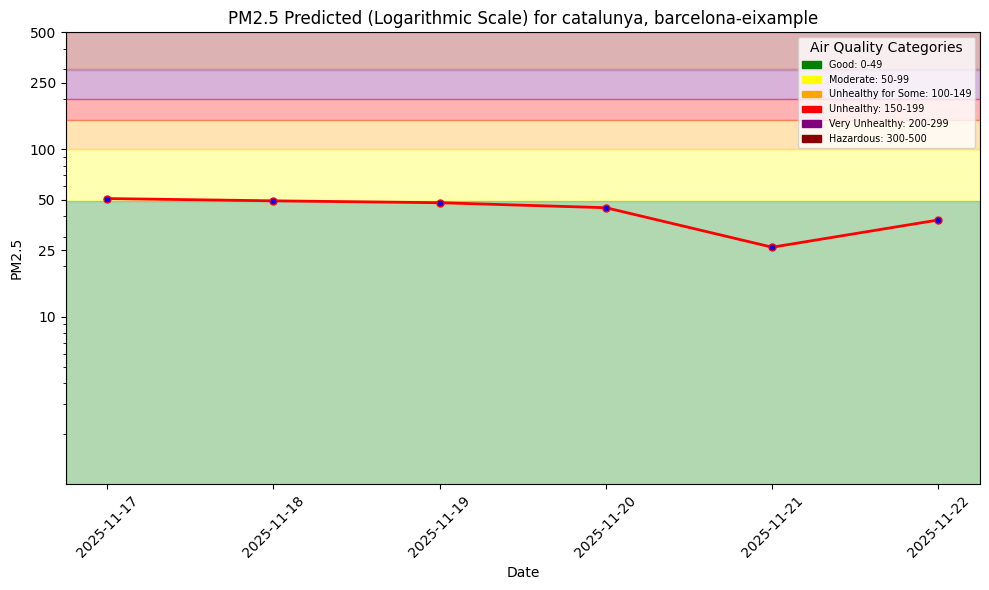

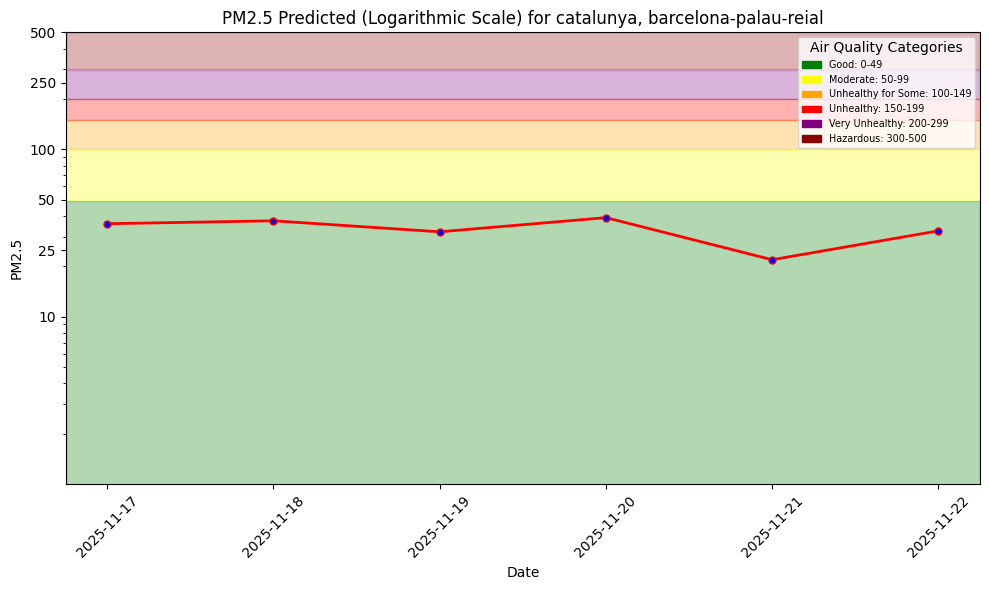

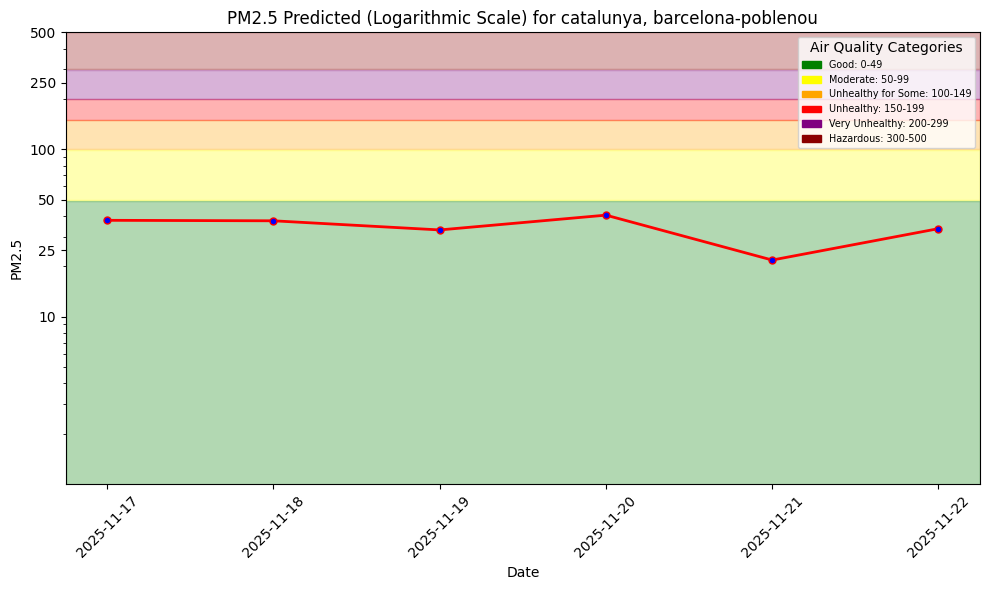

In [27]:
for street, data in batch_data_by_street.items():
    path_name = re.sub(r"[^A-Za-z0-9]+","_", street)
    pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast_{path_name}.png"
    plt = util.plot_air_quality_forecast(city, street, data, pred_file_path)
    plt.show()

In [28]:
batch_data_by_street['barcelona'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 6 entries, 4 to 3
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         6 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          6 non-null      float32                
 2   precipitation_sum            6 non-null      float32                
 3   wind_speed_10m_max           6 non-null      float32                
 4   wind_direction_10m_dominant  6 non-null      float32                
 5   city                         6 non-null      object                 
 6   rolling_mean                 6 non-null      float64                
 7   predicted_pm25               6 non-null      float32                
 8   street                       6 non-null      object                 
 9   country                      6 non-null      object                 
 10  days_before

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

In [30]:
# Get or create feature group
monitors_fg_by_street = {}
for street in streets:
    feature_name = 'aq_predictions_'+ re.sub(r"[^A-Za-z0-9]+","_", s)
    monitor_fg = fs.get_or_create_feature_group(
        name=feature_name,
        description='Air Quality prediction monitoring',
        version=2,
        primary_key=['city','street','date','days_before_forecast_day'],
        event_time="date"
    )
    monitor_fg.insert(batch_data_by_street[street], wait=True)
    monitors_fg_by_street[street] = monitor_fg

Uploading Dataframe: 100.00% |█| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time


Launching job: aq_predictions_barcelona_poblenou_2_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279126/jobs/named/aq_predictions_barcelona_poblenou_2_offline_fg_materialization/executions
2025-11-16 12:56:00,036 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-16 12:56:03,221 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-16 12:57:32,911 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-16 12:57:33,115 INFO: Waiting for log aggregation to finish.
2025-11-16 12:57:48,675 INFO: Execution finished successfully.


Uploading Dataframe: 100.00% |█| Rows 6/6 | Elapsed Time: 00:02 | Remaining Time


Launching job: aq_predictions_barcelona_poblenou_2_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279126/jobs/named/aq_predictions_barcelona_poblenou_2_offline_fg_materialization/executions
2025-11-16 12:58:07,451 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2025-11-16 12:58:10,652 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-16 12:59:43,880 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-16 12:59:44,086 INFO: Waiting for log aggregation to finish.
2025-11-16 12:59:52,876 INFO: Execution finished successfully.


Uploading Dataframe: 100.00% |█| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time


Launching job: aq_predictions_barcelona_poblenou_2_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279126/jobs/named/aq_predictions_barcelona_poblenou_2_offline_fg_materialization/executions
2025-11-16 13:00:10,753 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-16 13:00:13,952 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-16 13:01:53,377 INFO: Waiting for execution to finish. Current state: SUCCEEDING. Final status: UNDEFINED
2025-11-16 13:01:56,593 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-16 13:01:56,799 INFO: Waiting for log aggregation to finish.
2025-11-16 13:02:05,454 INFO: Execution finished successfully.


Uploading Dataframe: 100.00% |█| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time


Launching job: aq_predictions_barcelona_poblenou_2_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279126/jobs/named/aq_predictions_barcelona_poblenou_2_offline_fg_materialization/executions
2025-11-16 13:02:23,539 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-16 13:02:26,755 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-16 13:04:06,539 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-16 13:04:06,743 INFO: Waiting for log aggregation to finish.
2025-11-16 13:04:18,912 INFO: Execution finished successfully.


Uploading Dataframe: 100.00% |█| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time


Launching job: aq_predictions_barcelona_poblenou_2_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279126/jobs/named/aq_predictions_barcelona_poblenou_2_offline_fg_materialization/executions
2025-11-16 13:04:36,705 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-16 13:04:39,937 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-16 13:06:26,419 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-16 13:06:26,629 INFO: Waiting for log aggregation to finish.
2025-11-16 13:06:38,825 INFO: Execution finished successfully.


Uploading Dataframe: 100.00% |█| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time


Launching job: aq_predictions_barcelona_poblenou_2_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279126/jobs/named/aq_predictions_barcelona_poblenou_2_offline_fg_materialization/executions
2025-11-16 13:06:56,779 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2025-11-16 13:07:00,018 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-16 13:08:46,197 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-16 13:08:46,398 INFO: Waiting for log aggregation to finish.
2025-11-16 13:08:58,430 INFO: Execution finished successfully.


In [32]:
monitors_df_by_street = {}
for s, m in monitors_fg_by_street.items():
    monitors_df_by_street[s] = m.filter(m.days_before_forecast_day == 1).read()


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.52s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.59s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.72s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.61s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.60s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.62s) 


In [41]:
monitors_fg_by_street['barcelona'].read().info()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.86s) 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         36 non-null     datetime64[us, Etc/UTC]
 1   temperature_2m_mean          36 non-null     float32                
 2   precipitation_sum            36 non-null     float32                
 3   wind_speed_10m_max           36 non-null     float32                
 4   wind_direction_10m_dominant  36 non-null     float32                
 5   city                         36 non-null     object                 
 6   rolling_mean                 36 non-null     float64                
 7   predicted_pm25               36 non-null     float32                
 8   street                       36 non-null     object               

In [ ]:
weather_df = weather_fg.read()
weather['rolling_mean'] = air_quality_df['rolling_mean']

In [33]:
air_quality_fg = fs.get_feature_group(name='air_quality_per_city', version=2)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.66s) 


,date,pm25,street,url,country,city,rolling_mean
0,2025-09-13 00:00:00+00:00,40.0,barcelona-gracia-st.gervasi,https://api.waqi.info/feed/@11758,spain,catalunya,35.333332
1,2025-06-05 00:00:00+00:00,43.0,barcelona-poblenou,https://api.waqi.info/feed/@10534/,spain,catalunya,33.000000
2,2023-08-02 00:00:00+00:00,49.0,barcelona-gracia-st.gervasi,https://api.waqi.info/feed/@11758,spain,catalunya,31.333334
3,2023-04-01 00:00:00+00:00,50.0,barcelona-gracia-st.gervasi,https://api.waqi.info/feed/@11758,spain,catalunya,25.000000
4,2025-06-09 00:00:00+00:00,55.0,barcelona-gracia-st.gervasi,https://api.waqi.info/feed/@11758,spain,catalunya,60.333332
...,...,...,...,...,...,...,...
7119,2025-11-16 00:00:00+00:00,65.0,barcelona-eixample,https://api.waqi.info/feed/@6669/,spain,catalunya,56.000000
7120,2025-11-16 00:00:00+00:00,17.0,barcelona-palau-reial,https://api.waqi.info/feed/@10532,spain,catalunya,56.000000
7121,2025-11-16 00:00:00+00:00,65.0,barcelona-gracia-st.gervasi,https://api.waqi.info/feed/@11758,spain,catalunya,56.000000
7122,2025-11-16 00:00:00+00:00,17.0,barcelona-parc-vall-dhebron,https://api.waqi.info/feed/@10533/,spain,catalunya,56.000000


In [51]:
hindcasts={}
for street, monitor in monitors_df_by_street.items():
    outcome_df = air_quality_df[air_quality_df["street"] == street][['date', 'pm25']]
    preds_df =  monitor[['date', 'predicted_pm25']]
    
    hindcast_df = pd.merge(preds_df, outcome_df, on="date")
    hindcast_df = hindcast_df.sort_values(by=['date'])
    
    # If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
    if len(hindcast_df) == 0:
        hindcast_df = util.backfill_predictions_for_monitoring_v2(weather_fg, air_quality_df, monitors_fg_by_street[street], xgb_models[street])
    hindcasts[street]=hindcast_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.62s) 


Uploading Dataframe: 100.00% |█| Rows 56/56 | Elapsed Time: 00:01 | Remaining Ti


Launching job: aq_predictions_barcelona_poblenou_2_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279126/jobs/named/aq_predictions_barcelona_poblenou_2_offline_fg_materialization/executions
2025-11-16 13:34:33,164 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-16 13:34:36,362 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-16 13:36:45,940 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-16 13:36:46,102 INFO: Waiting for log aggregation to finish.
2025-11-16 13:37:05,220 INFO: Execution finished successfully.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.61s) 


Uploading Dataframe: 100.00% |█| Rows 56/56 | Elapsed Time: 00:02 | Remaining Ti


Launching job: aq_predictions_barcelona_poblenou_2_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279126/jobs/named/aq_predictions_barcelona_poblenou_2_offline_fg_materialization/executions
2025-11-16 13:37:25,669 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-16 13:37:28,883 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-16 13:39:34,632 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-16 13:39:34,836 INFO: Waiting for log aggregation to finish.
2025-11-16 13:39:53,694 INFO: Execution finished successfully.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.85s) 


Uploading Dataframe: 100.00% |█| Rows 56/56 | Elapsed Time: 00:01 | Remaining Ti


Launching job: aq_predictions_barcelona_poblenou_2_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279126/jobs/named/aq_predictions_barcelona_poblenou_2_offline_fg_materialization/executions
2025-11-16 13:40:13,385 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-16 13:40:16,617 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-16 13:42:22,630 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-16 13:42:22,789 INFO: Waiting for log aggregation to finish.
2025-11-16 13:43:09,028 INFO: Execution finished successfully.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.95s) 


Uploading Dataframe: 100.00% |█| Rows 56/56 | Elapsed Time: 00:01 | Remaining Ti


Launching job: aq_predictions_barcelona_poblenou_2_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279126/jobs/named/aq_predictions_barcelona_poblenou_2_offline_fg_materialization/executions
2025-11-16 13:43:29,833 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-16 13:43:39,471 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-16 13:46:46,073 INFO: Waiting for execution to finish. Current state: SUCCEEDING. Final status: UNDEFINED
2025-11-16 13:46:52,660 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-16 13:46:52,822 INFO: Waiting for log aggregation to finish.
2025-11-16 13:47:11,881 INFO: Execution finished successfully.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.54s) 


Uploading Dataframe: 100.00% |█| Rows 56/56 | Elapsed Time: 00:01 | Remaining Ti


Launching job: aq_predictions_barcelona_poblenou_2_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279126/jobs/named/aq_predictions_barcelona_poblenou_2_offline_fg_materialization/executions
2025-11-16 13:47:31,309 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-16 13:47:34,528 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-16 13:49:43,600 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-16 13:49:43,814 INFO: Waiting for log aggregation to finish.
2025-11-16 13:50:02,935 INFO: Execution finished successfully.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (4.56s) 


Uploading Dataframe: 100.00% |█| Rows 56/56 | Elapsed Time: 00:01 | Remaining Ti


Launching job: aq_predictions_barcelona_poblenou_2_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279126/jobs/named/aq_predictions_barcelona_poblenou_2_offline_fg_materialization/executions
2025-11-16 13:50:25,399 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-16 13:50:32,148 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-16 13:52:22,538 INFO: Waiting for log aggregation to finish.
2025-11-16 13:52:45,163 INFO: Execution finished successfully.


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

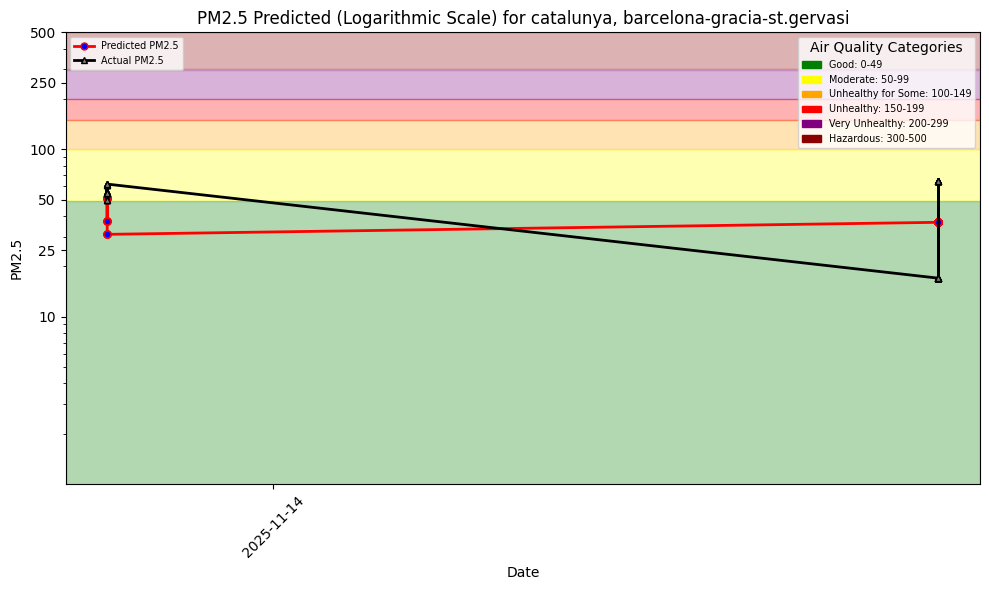

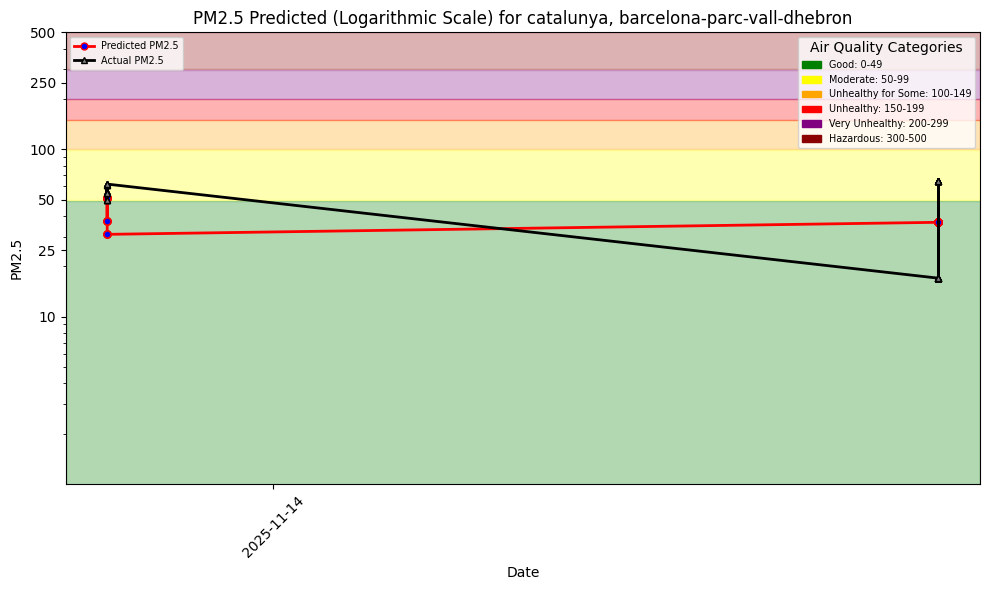

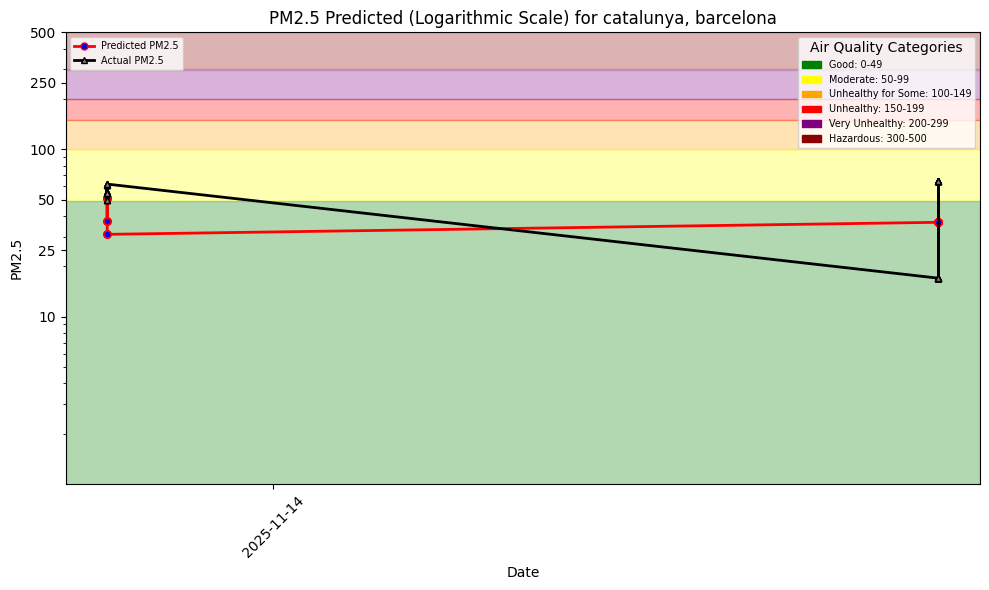

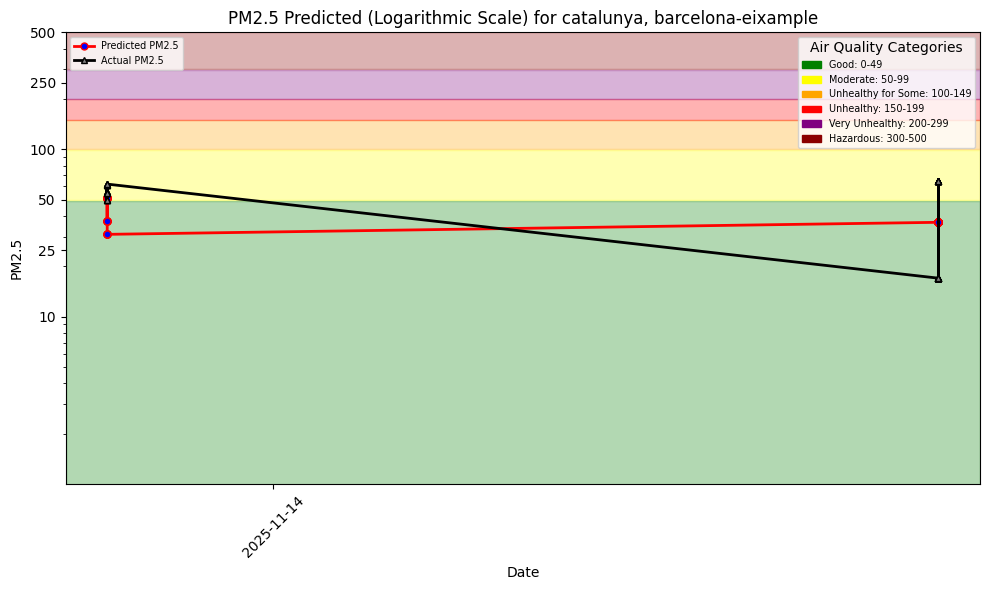

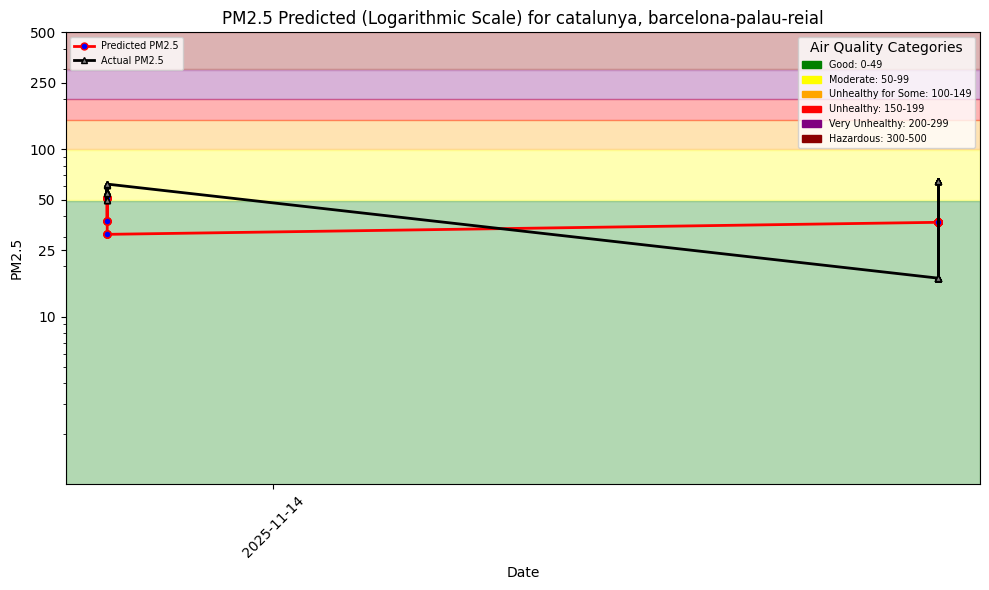

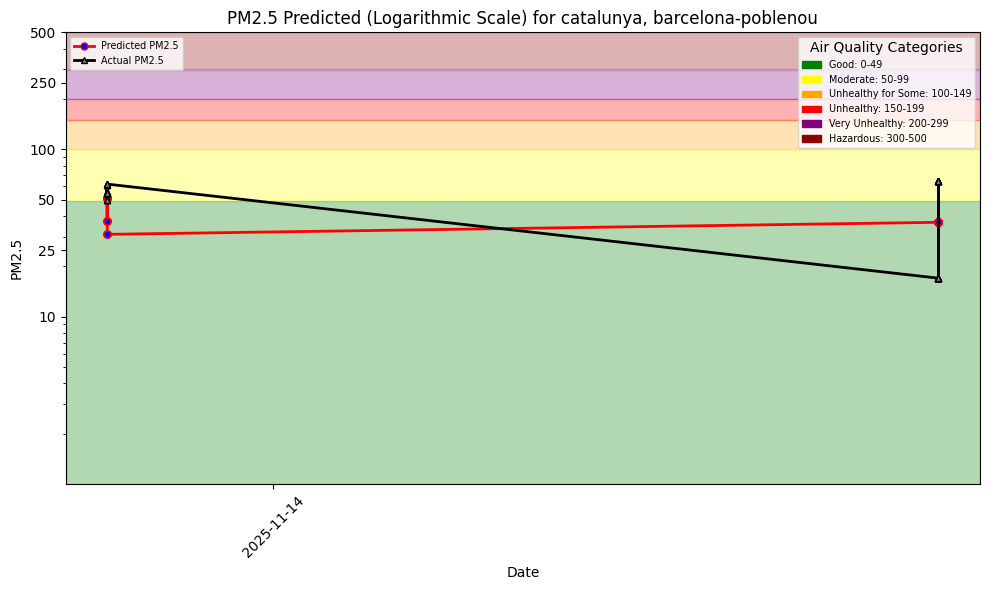

In [53]:
for s, hindcast in hindcasts.items():
    path_name=re.sub(r"[^A-Za-z0-9]+","_", street)
    hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day_{path_name}.png"
    plt = util.plot_air_quality_forecast(city, s, hindcast, hindcast_file_path, hindcast=True)
    plt.show()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [27]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
for s in streets:
    dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}_{path_name}", overwrite=True)
    dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}_{path_name}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality_v2")

Uploading /home/zohra/mlfs-book/docs/air-quality/assets/img/pm25_forecast_v2.png: 0.000%|          | 0/44329 e…

Uploading /home/zohra/mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1day_v2.png: 0.000%|          | 0/44…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1279126/settings/fb/path/Resources/airquality_v2


---